<a href="https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/ja/1-Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-OpenJij 入門

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/ja/1-Introduction.ipynb)

OpenJijは Isingモデル, QUBOのヒューリステック最適化ライブラリです。  
最適化のコア部分はc++で実装されていますが、Pythonインターフェースを備えているため、Pythonで簡単に書くことができます。

pip でインストールしましょう。numpy が必要です。

In [ ]:
# !pip install openjij

In [1]:
!pip show openjij  # openjij == 0.0.8 を仮定します。

Name: openjij
Version: 0.0.8
Summary: Framework for the Ising model and QUBO
Home-page: https://openjij.github.io/OpenJij/
Author: Jij Inc.
Author-email: openjij@j-ij.com
License: Apache License 2.0
Location: /usr/local/miniconda3/envs/openjij3/lib/python3.7/site-packages/openjij-0.0.8-py3.7-macosx-10.7-x86_64.egg
Requires: numpy, requests, debtcollector, dimod
Required-by: 


### Ising model

Ising model は物理で扱われるモデルで以下のように書かれます。

$$H(\{\sigma_i\}) = \sum_{i > j} J_{ij}\sigma_i \sigma_j + \sum_{i=1}^N h_i \sigma_i$$
$$\sigma_i \in \{-1, 1\}, i=1,\cdots N$$

$H(\{\sigma_i\})$がハミルトニアンと呼ばれますが、エネルギーやコスト関数だと思ってください。  
$\sigma_i$は2値$(1, -1)$を取る変数です。  

> $\sigma_i$は物理ではスピンという物理量に対応するため、スピン変数もしくは単純にスピンと呼ばれることもあります。  
> スピンとは小さな磁石のようなものです。-1 が磁石が上向き、1が下向きのように変数の値と物理(磁石の向き)が対応します。

$H$は変数の組み合わせ$\{\sigma_i\} = \{\sigma_1, \sigma_2, \cdots, \sigma_N\}$に依存します。  
$J_{ij}, h_i$が与えられる問題を表し、それぞれ、相互作用、縦磁場と呼ばれます。

OpenJijは$J_{ij} と h_i$が与えられたときに$H(\{\sigma_i\})$を最小化するスピン変数の組み$\{\sigma_i\}$を探してくれるライブラリです。

具体的な例を一つ見ましょう。

## OpenJijに問題を投げてみる

変数の数が$N=5$で縦磁場と相互作用が

$$h_i = -1~\text{for} ~\forall i, ~ J_{ij} = -1~\text{for} ~\forall i, j$$

だとしましょう。この場合全ての相互作用がマイナスなので各スピン変数は同じ値をとった方がエネルギーは低くなります。  
また縦磁場は全てマイナスです。この場合各スピンは1の値をとった方がエネルギーが低くなります。  
よってこの場合の答えは $\{\sigma_i\} = \{1, 1, 1, 1, 1\}$になります。

では、OpenJijを使って計算してみましょう。

In [1]:
import openjij as oj

# 問題を表す縦磁場と相互作用を作ります。OpenJijでは辞書型で問題を受け付けます。
N = 5
h = {i: -1 for i in range(N)}
J = {(i, j): -1 for i in range(N) for j in range(i+1, N)}

print('h_i: ', h)
print('Jij: ', J)

h_i:  {0: -1, 1: -1, 2: -1, 3: -1, 4: -1}
Jij:  {(0, 1): -1, (0, 2): -1, (0, 3): -1, (0, 4): -1, (1, 2): -1, (1, 3): -1, (1, 4): -1, (2, 3): -1, (2, 4): -1, (3, 4): -1}


In [2]:
# まず問題を解いてくれるSamplerのインスタンスを作ります。このインスタンスの選択で問題を解くアルゴリズムを選択できます。
sampler = oj.SASampler()
# samplerのメソッドに問題(h, J)を投げて問題を解きます。
response = sampler.sample_ising(h, J)

# 計算した結果(状態)は result.states に入っています。
print(response.states)

# もしくは添字付きでみるには samples を見ます。
print(response.samples)

[[1, 1, 1, 1, 1]]
[{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}]


## OpenJijの解説

では、上で解いてみたコードの解説をします。  
またOpenJijは現在インターフェースを2つ備えていて、上記で使ったものはD-Wave Oceanと同じようなインターフェースになっているので、OpenJijで慣れておけばOceanへの変更はそこまで負担にはならないかと思います。

> もう一つのインターフェースについてはここでは解説しませんが、OpenJijの仕組み`graph, method, algorithm`を直接使うことで拡張のしやすさを備えています。しかし現状は上記のセルで扱ったインターフェースを使えるようになるだけで十分でしょう。

### Sampler

先ほどは問題を辞書型で作ったあとに、Samplerのインスタンスを作りました。
```python
sampler = oj.SASampler()
```
ここでこのSamplerというのが、どういうアルゴリズム、マシンを使うかを選択するところになります。他のアルゴリズムを試したい時はこのSamplerを変更します。

> OpenJijで扱っているアルゴリズムはヒューリスティックな確率アルゴリズムで問題を解くたびに返す解が違ったり、必ずしも最適解を得ることができません。
> なので何回も解いてみてその中でよい解を探すという手法をとります。なので解をサンプリングするという気持ちを込めてSamplerと呼んでいます。

上のセルであつかった`SASampler`は`Simulated annealing`というアルゴリズムで解をサンプリングしてくるSamplerです。  
他にも

- SQASampler : Simulated quantum annealing(SQA) という量子アニーリングを古典コンピュータでシミュレーションするアルゴリズム.
- GPUSQASampler : SQAをGPUで実行するSampler. Chimeraグラフという特殊な構造のみが現状扱える. 不安定.

というSamplerが用意されています。

### sample_ising(h, J)
まあ書いてあるように問題を解く時は `.sample_ising(h, J)`はで問題を投げて解きます。

後から解説しますが、ちなみにIsingモデルと等価なQUBOの最適化を行う時は`.sample_qubo(Q)`を使います。

### Response

`.sample_ising(h, J)`はResponseクラスを返します。ResponseクラスにはSamplerが解いて出てきた解と各解のエネルギーが入っています。

- .states :
    - type : list(list(int))
    - iteration回だけおこなった分の解が格納されている
    > 物理ではスピンの配列(解)を状態と呼ぶことがあります。.statesにはiteration回だけ解いた解が格納されているので複数の状態を格納しているという気持ちを込めて .states としています。
- .energies:
    - type : list(float)
    - iteration回だけおこなった各解のエネルギーが格納されている
- .indices:
    - type: list(object)
    - 解がlistでstatesに入っているが、それに対応する各スピンの添字を格納する
- .samples:
    - type: dict(key=index, value=variable value)
    - 添字付きで状態が格納されています。
- .min_samples:
    - type: dict
    - 'min_states', 'num_occurences', 'min_energy' というキーが入っており、  
      それぞれ最小エネルギー値をとった状態のリスト, 各状態が現れた回数, 最小エネルギー値 となっています。

というパラメータが参照できます。わかりずらいので実際にコードを見てみましょう。



In [12]:
# 実は h, J の添字を示す、辞書のkeyは数値以外も扱えます。
h = {'a': -1, 'b': -1}
J = {('a', 'b'): -1, ('b', 'c'): 1}
sampler = oj.SASampler(num_reads=10)  # 10回 SAで解いてみる. num_reads という引数で10回分一気に解くことができます。
response = sampler.sample_ising(h, J)
response.states

[[1, -1, 1],
 [1, -1, 1],
 [1, -1, 1],
 [1, -1, 1],
 [1, -1, 1],
 [1, -1, 1],
 [1, -1, 1],
 [1, -1, 1],
 [1, -1, 1],
 [1, -1, 1]]

では response.states をみてみると、10回分の解が入っていることがわかります。  

> num_reads などコンストラクタで渡すパラメータは   
> .sample_ising などのサンプリングを実行するメソッドで上書きすることができます.
> ```
> response = sampler.sample_ising(h, J, num_reads=2)
> response.states
> > [[1, -1, 1],[1, -1, 1]]
> ```

今回は問題が簡単なので10回といても毎回同じ答え [1,-1,1] になっています。
次はエネルギーを見てみましょう.

In [13]:
response.energies

[-4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0]

エネルギーももちろん10回とも同じ値を取っています。  
`response.states`に入っている解はリストになっているので問題をセットした時の `a, b, c`という文字列との対応がわかりません。それは`response.indices`に入っています。

In [14]:
response.indices

['a', 'c', 'b']

添字と状態を対応づけたいときは 自分で ``dict(zip(response.indices, response.states[0]))`` などを使うか .samples を呼んでください。

In [7]:
response.samples

[{'a': 1, 'c': -1, 'b': 1},
 {'a': 1, 'c': -1, 'b': 1},
 {'a': 1, 'c': -1, 'b': 1},
 {'a': 1, 'c': -1, 'b': 1},
 {'a': 1, 'c': -1, 'b': 1},
 {'a': 1, 'c': -1, 'b': 1},
 {'a': 1, 'c': -1, 'b': 1},
 {'a': 1, 'c': -1, 'b': 1},
 {'a': 1, 'c': -1, 'b': 1},
 {'a': 1, 'c': -1, 'b': 1}]

最小エネルギー値を持った解のみが知りたいときは `.min_samples` が便利です。
解が縮退していた場合 `min_samples['min_states']` には複数の解があるかもしれないことに気をつけてください。

> 縮退 : 異なった解(状態)が同じエネルギー値(コスト値)を持つこと

In [8]:
response.min_samples

{'states': array([[ 1, -1,  1]]),
 'num_occurrences': array([10]),
 'min_energy': -4.0}

## QUBOを解いてみる

社会の問題を解きたい場合は Ising モデルよりも QUBO(Quadratic unconstraited binary optimization)として定式化した方が素直な場合が多いです。基本的には上記のIsing モデルを使って解いた場合と同じです。

QUBOは以下のように書かれます。

$$H(\{q_i\}) = \sum_{i\geq j} Q_{ij}q_i q_j$$
$$q_i \in \{0, 1\}$$

Ising モデルと違うのは2値変数が0 と 1を取ることです。$\sum, Q_{ij}$の取り方には他にもやり方がありますが($Q_{ij}$を対称行列にする)、今回は上記のように定式化しておきます。

> Ising モデル と QUBO は相互変換が可能という意味で等価です。
> $q_i = (\sigma_i + 1)/2$という変換式で変換が可能です。

QUBOでは$Q_{ij}$が与える問題で、$H(\{q_i\})$を最小化する0, 1の組み合わせ$\{q_i\}$を探せという問題になります。ほぼIsingモデルと一緒です。

また$q_i^2 = q_i$なので(0, 1しか値を取らないことからわかる)以下のように書き分けることができます。

$$H(\{q_i\}) = \sum_{i > j} Q_{ij}q_i q_j + \sum_i Q_{ii} q_i$$

つまり$Q_{ij}$の添字が同じところは $q_i$の1次項の係数に対応します。

OpenJijで解いてみましょう。

In [15]:
# Q_ij を辞書型でつくります。
Q = {(0, 0): -1, (0, 1): -1, (1, 2): 1, (2, 2): 1}
sampler = oj.SASampler()
# QUBOを解く時は .sample_qubo を使いましょう
response = sampler.sample_qubo(Q)
response.states

[[1, 1, 0]]

QUBOでは変数が 0, 1なので 0, 1で解がでていることがわかります。  
このような感じでOpenJij では IsingモデルとQUBOの最適化問題を解くことができます。

## 少し難しい問題を解いてみる

上で解いた問題は簡単すぎたので少し難しい問題を解いてみましょう。

変数の数が50個でランダムに$Q_{ij}$が振られたQUBOを解いてみたいと思います。

In [17]:
N = 50
# ランダムにQij を作る
import random
Q = {(i, j): random.uniform(-1, 1) for i in range(N) for j in range(i+1, N)}

# OpenJijで解く
sampler = oj.SASampler()
response = sampler.sample_qubo(Q, num_reads=100)

In [18]:
# エネルギーを少しみてみます。
response.energies[:5]

[-59.67307865595712,
 -59.67307865595712,
 -59.67307865595712,
 -59.56767374654641,
 -59.67307865595712]

エネルギーをみてみると先ほどとは違って違う値をとっていることがわかると思います。  
ランダムにQij を振った場合、一般に問題は難しくなります。なのでSASamplerも毎回同じ解を出すとは限りません。  
ではどのような解がでたのかエネルギーのヒストグラムで見てみましょう。

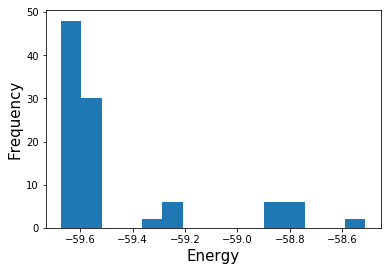

In [19]:
import matplotlib.pyplot as plt
plt.hist(response.energies, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが低ければ低いほど良いわけですが、たまにエネルギーが高い解もでていることがわかります。
しかし半数近くがエネルギーが低い解として出ているようです。

100回解いたわけですが、最適解はエネルギーが一番低い解なはずですから、解いた(サンプルした)解のうちエネルギーが一番低い解が最適解に近いはずなので、その解を.statesから探します。
> 注意: SAは必ずしも最適解を出せないのでここでエネルギーが一番低い解を選んでも最適解であるという保証はありません。  
> あくまで近似解です。

In [20]:
import numpy as np

min_samples = response.min_samples

min_samples

{'states': array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 1, 1, 1, 1, 1]]),
 'num_occurrences': array([48]),
 'min_energy': -59.67307865595712}

これでエネルギーが低い解を得ることができました。この`min_states`に入っている解が今回解いた近似解です。
`min_states`に入っている解はエネルギーは同じですが、問題によってはスピンの配列がことなることもあります(エネルギーが同じで解が違う状態があることを「縮退している」と言います)。

なので上記のようにしてエネルギーが低い状態を選んだあとにあとは、好みのスピン配列を`min_state`から選んで「問題を近似的に解いた。」
ということになります。  

次回は "2-Evaluation" で Time to solution や残留エネルギーなど解をはかる指標について説明します。